# Modelling a Fuel Assembly for a PWR type-like Reactor

This file contains an exercise about a realistic assembly made by 17x17 grid of fuel rods

Control Rods, Springs, Free volumes in the rods are not modelled since this is a simple code to
exercise with the definitions of Universes and Cells for fuel assemblies, thus a thorough description
of the fuel rod is not provided.

The code is developed using the Git Project concernig modelling assemblies and pincells provided by OpenMC ([Example Jupyter Notebooks](https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks)) as example!

In [1]:
import numpy as np
import openmc

In [2]:
# MATERIALS

#fuel material definition: UO2
fuel = openmc.Material(name='UO2 fuel')
fuel.set_density('g/cm3', 10.97)
fuel.add_nuclide('U235', 3.5e-04)
fuel.add_nuclide('U238', 2.3e-02)
fuel.add_nuclide('O16', 4.7e-02)

#helium for the gap
#helium = openmc.Material(name='Helium gas')
#helium.add_nuclide('He3', 4.8e-10)
#helium.add_nuclide('He4', 2.4e-04)

#Zirconium-alloy for the Cladding
zirc = openmc.Material(name='Zirconium')
zirc.set_density('g/cm3', 6.55)
zirc.add_nuclide('Zr90', 2.1827e-2)
zirc.add_nuclide('Zr91', 4.7600e-3)
zirc.add_nuclide('Zr92', 7.2758e-3)
zirc.add_nuclide('Zr94', 7.3734e-3)
zirc.add_nuclide('Zr96', 1.1879e-3)

#Borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4672e-2)
water.add_nuclide('B10', 8.0042e-6)
water.add_nuclide('B11', 3.2218e-5)
water.add_s_alpha_beta('c_H_in_H2O')

materials_list = [fuel, zirc, water]
materials = openmc.Materials(materials_list)
materials.export_to_xml()


/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

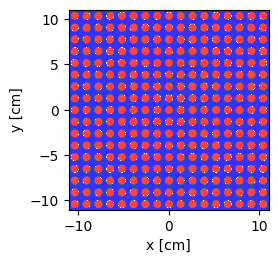

In [3]:
#GEOMETRY

pitch = 1.3 #cm
r0 = 0.0646 #cm #spring
r1 = 0.4058 #cm
r2 = 0.4140 #cm
r3 = 0.4750 #cm

height_fuel = 200 #cm
height_spring = 13.49 #cm
height_caps = 1.205 #cm
total_height = height_fuel + height_spring + 2*height_caps

#Fuel Region
fuel_cylinder = openmc.ZCylinder(r=r1)
max_plane_fuel = openmc.ZPlane(z0=height_fuel/2) 
min_plane_fuel = openmc.ZPlane(z0=-height_fuel/2)
fuel_region = -fuel_cylinder & +min_plane_fuel & -max_plane_fuel

#Zirconium Region
clad_inner_cyl = openmc.ZCylinder(r=r2)
clad_outer_cyl = openmc.ZCylinder(r=r3)
cap_cylinder = openmc.ZCylinder(r=r2)
spring_cyl = openmc.ZCylinder(r=r0)
max_plane_clad = openmc.ZPlane(z0=(height_fuel/2 + height_spring + height_caps), boundary_type='reflective')
min_plane_clad = openmc.ZPlane(z0=-(height_fuel/2 + height_caps), boundary_type='reflective')
max_plane_cap = openmc.ZPlane(z0=(height_fuel/2 + height_spring))
min_plane_cap = openmc.ZPlane(z0=-(height_fuel/2))

zirc_region = (+clad_inner_cyl & -clad_outer_cyl & -max_plane_clad & +min_plane_clad) | (-cap_cylinder & -max_plane_clad & +max_plane_cap) | (-cap_cylinder & +min_plane_clad & -min_plane_cap)

#Water Region
east = openmc.XPlane(x0 = pitch/2, boundary_type='reflective')
west = openmc.XPlane(x0 = -pitch/2, boundary_type='reflective')
nord = openmc.YPlane(y0 = pitch/2, boundary_type='reflective')
sud = openmc.YPlane(y0 = -pitch/2, boundary_type='reflective')
water_region = +clad_outer_cyl & -east & +west & +sud & -nord & -max_plane_clad & +min_plane_clad

#CELLS
fuel_cell = openmc.Cell(fill=fuel, region=fuel_region)
zirc_cell = openmc.Cell(fill=zirc, region=zirc_region)
water_cell = openmc.Cell(fill=water, region=water_region)

#UNIVERSE single channel: the various cells constitute a single group called universe
single_channel_univ = openmc.Universe(cells=[fuel_cell, zirc_cell, water_cell])

#ASSEMBLY - Rectangular Lattice: the model allows to create the assembly as constituted by universes
n_rods = 17
assembly_pitch = n_rods*pitch
assembly = openmc.RectLattice(name='Fuel Assembly')
assembly.pitch = (pitch, pitch) # single element pitch
assembly.lower_left = (-assembly_pitch/2, -assembly_pitch/2) # position of the whole ensamble
assembly.universes = np.full((n_rods, n_rods), single_channel_univ) # filling all the positions with the single channel universe created

#we define the outer border and then we fill the geometry with the lattice of the assembly to have a Cell: this allows plotting!!
outer_boundary = openmc.model.rectangular_prism(width=assembly_pitch, height=assembly_pitch, origin=(0,0))
main_cell = openmc.Cell(fill=assembly, region= outer_boundary)

assembly_univ = openmc.Universe(cells=[main_cell])
assembly_univ.plot(width=(assembly_pitch, assembly_pitch), colors = {fuel: [255, 67, 67], zirc: [100, 100, 100], water: [50, 50, 250]})

In [4]:
# The export of geometry is possible only with cells, thus using the main_cell filled with universes

geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

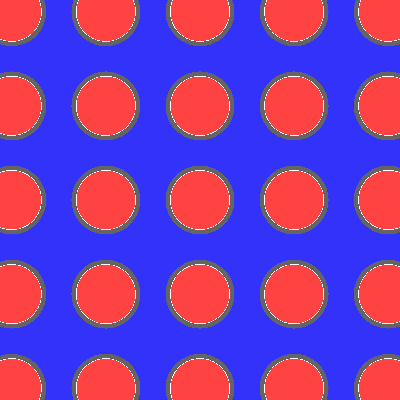

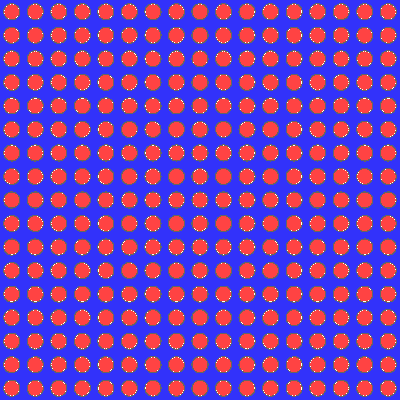

In [5]:
#PLOTS inline

plot1 = openmc.Plot()
plot1.basis = 'xy'
plot1.origin = (0,0,0)
plot1.width = (assembly_pitch/4, assembly_pitch/4)
plot1.colors = {fuel: [255, 67, 67], zirc: [100, 100, 100], water: [50, 50, 250]}

plot2 = openmc.Plot()
plot2.basis = 'xy'
plot2.origin = (0,0,0)
plot2.width = (assembly_pitch, assembly_pitch)
plot2.colors = {fuel: [255, 67, 67], zirc: [100, 100, 100], water: [50, 50, 250]}

plots = openmc.Plots([plot1, plot2])
openmc.plot_inline(plots)